<a href="https://colab.research.google.com/github/DPM2310/hackaboys/blob/main/Oct6-7/Tarea7Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Encuentra los parámetros w0 y w1 para el conjunto de datos de los tiempos en carreras de 100 usando cadenas de markov, en particular usando la librería emcee (https://emcee.readthedocs.io/en/stable/tutorials/line/)

2. Muestra evidencia de que las cadenas han convergido (triangle plots, secuencias de caminadores , criterio de Gelman-Rubin, etc.)

3. Compara tus resultados con los obtenidos con tu propia implementación del método de metropolis.

In [2]:
!pip install emcee
!pip install corner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 976.0 kB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

from scipy.optimize import minimize
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from numpy.linalg import linalg

In [4]:
# Cargamos los datos desde Drive

drive.mount('/content/drive')
file ="/content/drive/MyDrive/Machine Learning/Data/olympic100m_men.txt"
data=np.loadtxt(file,delimiter=",").T

Mounted at /content/drive


Text(0, 0.5, 'Velocidad')

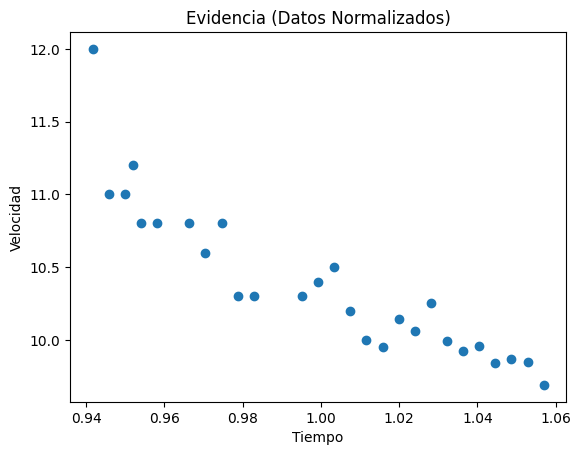

In [6]:
# Graficamos los datos

dataN = (data-np.mean(data))/np.std(data)
x = dataN[0]
y = data[1]
plt.plot(x,y,'o')
plt.title("Evidencia (Datos Normalizados)")
plt.xlabel("Tiempo")
plt.ylabel("Velocidad")

Parámetros inciales
b = 23.33379128347669
m = -12.948368137147472


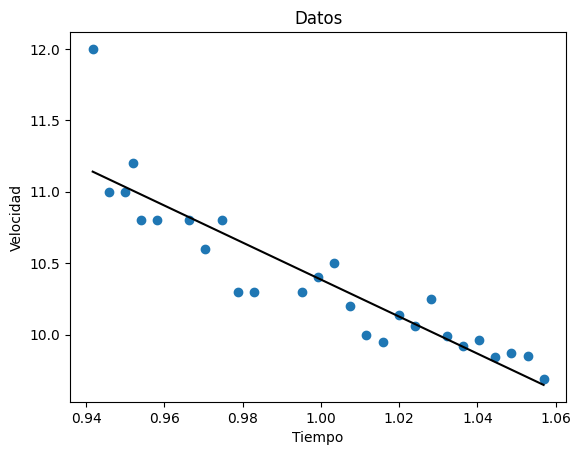

In [10]:
# Aplicamos el metodo de minimos cuadrados para obtener los valores iniciales

def Wpoly(x, y, n):
     X = np.vstack([np.ones_like(x)])
     for i in range(1,n+1):
      Xa = np.vstack([x**i])
      X = np.concatenate([X, Xa])
      Xm = np.matmul(X,X.T)
      invx = np.linalg.inv(Xm)
      Xt = np.matmul(X,y)
      W = np.matmul(invx,Xt)
     return W

minC = Wpoly(x,y,1)
x0 = np.linspace(min(x), max(x), 27)
Ym = minC[0]+x0*minC[1]

# Graficamos lo obtenido
plt.plot(x,y,'o',label = "Dispersión ")
plt.plot(x0,Ym,label = 'Mínimos cuadrados ', color = 'black')
plt.title("Datos")
plt.xlabel("Tiempo")
plt.ylabel("Velocidad")
print(f"Parámetros inciales\nb = {minC[0]}\nm = {minC[1]}")

In [11]:
# Aplicamos el emcee

# Asignamos los parámetros inciales
N = len(x)
b_true = minC[0]
m_true = minC[1]
i = np.random.randint(N)
f_true = Ym[i]
yerr = 0.1 + 0.5 * np.random.rand(N) # Error aleatorio en Y

In [12]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Maximum likelihood estimates:
m = -13.201
b = 23.593
f = 0.019


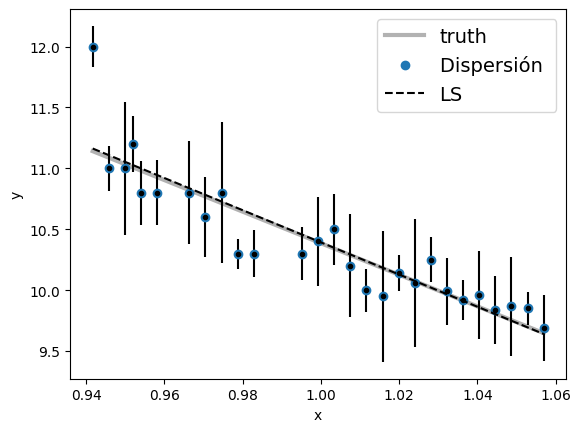

In [13]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x,y,'o',label="Dispersión ")
plt.plot(x0, b_ml+x0*m_ml, "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [15]:
pos = soln.x + 1e-4 * np.random.randn(25, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))

sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 739.03it/s] 


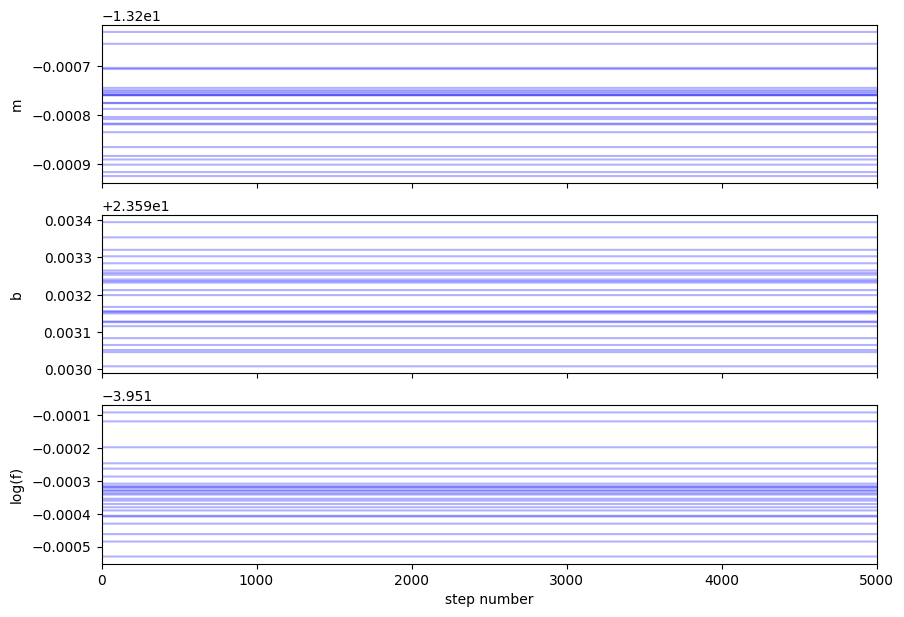

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "b", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
tau = sampler.get_autocorr_time()
print(tau)
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

[nan nan nan]
(8150, 3)


/usr/local/lib/python3.10/dist-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


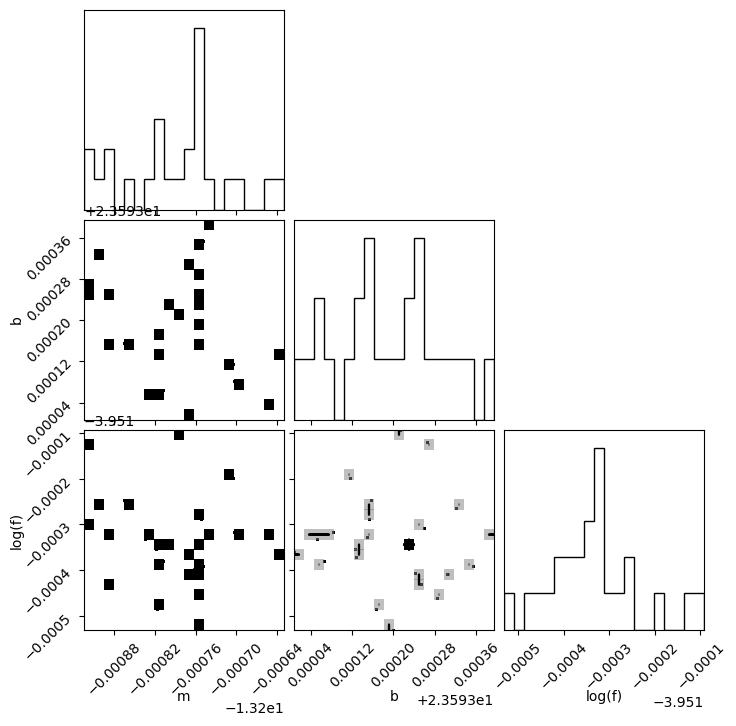

In [19]:
fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]);